In [ ]:
%pip install sdv
%pip install catboost

In [1]:
#import необходимых модулей

import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [2]:
#Считывание данных в DataFrame 
train = pd.read_csv('/Users/nikitaromanov/Downloads/train_dataset_train.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})
test = pd.read_csv('/Users/nikitaromanov/Downloads/test_dataset_test.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str})
train

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00.0,Гурьевск,08.21,young,1
1,0,A00.0,Калининград,03.20,children,1
2,0,A00,Гусев,03.19,children,1
3,0,A00,Калининград,01.22,children,1
4,0,A00,Калининград,02.18,children,1
...,...,...,...,...,...,...
2212388,1,Z99.1,Гурьевск,12.21,children,1
2212389,1,Z99.8,Калининград,10.21,young,1
2212390,1,Z99.9,Калининград,04.19,children,2
2212391,1,Z99.9,Калининград,08.19,children,1


### Исследование

In [3]:
train.describe()

,PATIENT_ID_COUNT
count,2.212393e+06
mean,5.847853e+00
std,6.042780e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.353200e+04


<AxesSubplot:xlabel='PATIENT_SEX', ylabel='count'>

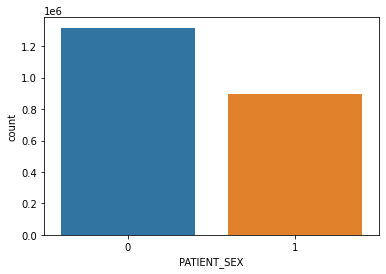

In [123]:
sns.countplot(x='PATIENT_SEX', data=train)

count         2212393
unique            118
top       Калининград
freq           617129
Name: ADRES, dtype: object

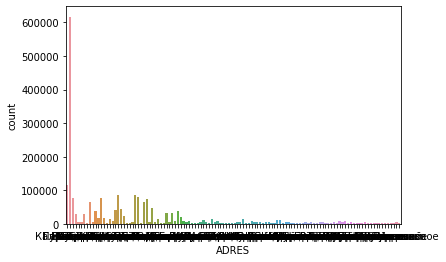

In [ ]:
sns.countplot(x='ADRES', data=train)
train.ADRES.describe()

count     2212393
unique         51
top         10.19
freq        63145
Name: VISIT_MONTH_YEAR, dtype: object

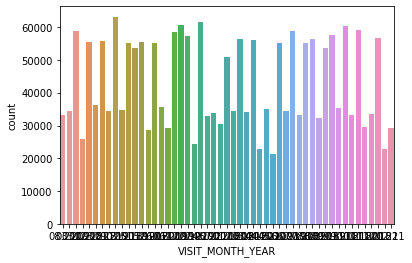

In [ ]:
sns.countplot(x='VISIT_MONTH_YEAR', data=train)
train.VISIT_MONTH_YEAR.describe()

<AxesSubplot:xlabel='AGE_CATEGORY', ylabel='count'>

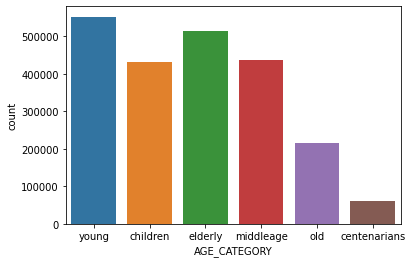

In [ ]:
sns.countplot(x='AGE_CATEGORY', data=train)

### Делаем фичи

In [129]:
coders = []
cat_columns = ['ADRES', 'PATIENT_SEX', 'AGE_CATEGORY', 'letter']

def make_features(dataset, is_training = True):

        new_dataset = pd.concat([dataset[['MKB_CODE', 'ADRES', 'VISIT_MONTH_YEAR', 'PATIENT_SEX', 'AGE_CATEGORY']], 
                dataset.VISIT_MONTH_YEAR.apply(lambda x: x.split('.')[0]), 
                dataset.VISIT_MONTH_YEAR.apply(lambda x: x.split('.')[1]),
                dataset.MKB_CODE.apply(lambda x:  x[0]),
                dataset.MKB_CODE.apply(lambda x:  x[1:]),
                dataset.VISIT_MONTH_YEAR.apply(lambda x: x.split('.')[0]).apply(lambda x: int(x) // 3).apply(lambda x: x if x != 4 else 0)
                ], axis=1)

        new_dataset.columns = ['MKB_CODE', 'ADRES', 'VISIT_MONTH_YEAR', 'PATIENT_SEX', 'AGE_CATEGORY', 'month', 'year', 'letter', 'number', 'season']

        new_dataset.number = new_dataset.number.astype('float')
        new_dataset.month = new_dataset.month.astype('int')
        new_dataset.year = new_dataset.year.astype('int')
        new_dataset.PATIENT_SEX = new_dataset.PATIENT_SEX.astype('int')

        global coders

        if is_training:
                for column in cat_columns:
                        le = sklearn.preprocessing.LabelEncoder()
                        new_dataset[column] = le.fit_transform(new_dataset[column].astype('category'))
                        coders.append(le)
        else:
                for i in range(len(cat_columns)):
                        new_dataset[cat_columns[i]] = coders[i].transform(new_dataset[cat_columns[i]].astype('category'))

        new_dataset.number = (new_dataset.number-new_dataset.number.min()) / (new_dataset.number.max()-new_dataset.number.min())

        return new_dataset

In [130]:
X = make_features(train)
y = train[['PATIENT_ID_COUNT']]

print(X.columns.to_list())
X

['MKB_CODE', 'ADRES', 'VISIT_MONTH_YEAR', 'PATIENT_SEX', 'AGE_CATEGORY', 'month', 'year', 'letter', 'number', 'season']


,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season
0,A00.0,12,08.21,0,5,8,21,0,0.000000,2
1,A00.0,29,03.20,0,1,3,20,0,0.000000,1
2,A00,14,03.19,0,1,3,19,0,0.000000,1
3,A00,29,01.22,0,1,1,22,0,0.000000,0
4,A00,29,02.18,0,1,2,18,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
2212388,Z99.1,12,12.21,1,1,12,21,24,0.991992,0
2212389,Z99.8,29,10.21,1,5,10,21,24,0.998999,3
2212390,Z99.9,29,04.19,1,1,4,19,24,1.000000,1
2212391,Z99.9,29,08.19,1,1,8,19,24,1.000000,2


In [131]:
X['PATIENT_ID_COUNT'] = y
X

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,PATIENT_ID_COUNT
0,A00.0,12,08.21,0,5,8,21,0,0.000000,2,1
1,A00.0,29,03.20,0,1,3,20,0,0.000000,1,1
2,A00,14,03.19,0,1,3,19,0,0.000000,1,1
3,A00,29,01.22,0,1,1,22,0,0.000000,0,1
4,A00,29,02.18,0,1,2,18,0,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2212388,Z99.1,12,12.21,1,1,12,21,24,0.991992,0,1
2212389,Z99.8,29,10.21,1,5,10,21,24,0.998999,3,1
2212390,Z99.9,29,04.19,1,1,4,19,24,1.000000,1,2
2212391,Z99.9,29,08.19,1,1,8,19,24,1.000000,2,1


In [132]:
final_table = None
for j in range(18, 23):
    current = X[X.year == j].sort_values(by='month')
    if j == 18:
        current.VISIT_MONTH_YEAR = current.VISIT_MONTH_YEAR.astype('category').cat.codes
        final_table = current
    else:
        final_table = pd.concat([final_table, current], ignore_index=True)
        final_table.VISIT_MONTH_YEAR = final_table.VISIT_MONTH_YEAR.astype('category').cat.codes
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,PATIENT_ID_COUNT
0,L20.8,12,0,0,2,1,18,11,0.208208,0,1
1,H25.9,40,0,1,2,1,18,7,0.259259,0,1
2,T80.9,29,0,1,3,1,18,19,0.809810,0,1
3,D32.0,72,0,0,4,1,18,3,0.320320,0,1
4,K29.9,12,0,1,2,1,18,10,0.299299,0,2
...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,2
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,1
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,1
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,1


Фичи за всё время

In [134]:
final_table['connected'] = final_table['AGE_CATEGORY'].astype('str') + '_' + final_table['ADRES'].astype('str') + '_' + final_table['MKB_CODE'].astype('str')
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,PATIENT_ID_COUNT,connected
0,L20.8,12,0,0,2,1,18,11,0.208208,0,1,2_12_L20.8
1,H25.9,40,0,1,2,1,18,7,0.259259,0,1,2_40_H25.9
2,T80.9,29,0,1,3,1,18,19,0.809810,0,1,3_29_T80.9
3,D32.0,72,0,0,4,1,18,3,0.320320,0,1,4_72_D32.0
4,K29.9,12,0,1,2,1,18,10,0.299299,0,2,2_12_K29.9
...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,2,3_12_G35
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,1,0_12_H26.4
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,1,2_26_H26.4
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,1,4_98_H26.2


In [135]:
b = final_table.groupby('connected')['PATIENT_ID_COUNT'].agg(['sum', 'mean', 'max', 'last']) 
final_table = final_table.merge(b, left_on='connected', right_index=True, how='left')
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,PATIENT_ID_COUNT,connected,sum,mean,max,last
0,L20.8,12,0,0,2,1,18,11,0.208208,0,1,2_12_L20.8,24,1.411765,2,1
1,H25.9,40,0,1,2,1,18,7,0.259259,0,1,2_40_H25.9,4,1.000000,1,1
2,T80.9,29,0,1,3,1,18,19,0.809810,0,1,3_29_T80.9,6,1.200000,2,1
3,D32.0,72,0,0,4,1,18,3,0.320320,0,1,4_72_D32.0,17,1.133333,2,1
4,K29.9,12,0,1,2,1,18,10,0.299299,0,2,2_12_K29.9,486,5.115789,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,2,3_12_G35,64,1.361702,3,2
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,1,0_12_H26.4,5,1.000000,1,1
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,1,2_26_H26.4,25,1.086957,2,1
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,1,4_98_H26.2,193,2.539474,12,1


In [136]:
final_table['fully_connected'] = final_table['AGE_CATEGORY'].astype('str') + '_' + final_table['ADRES'].astype('str') + '_' + final_table['MKB_CODE'].astype('str') + '_' + final_table['PATIENT_SEX'].astype('str') + '_' + final_table['VISIT_MONTH_YEAR'].astype('str')
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,PATIENT_ID_COUNT,connected,sum,mean,max,last,fully_connected
0,L20.8,12,0,0,2,1,18,11,0.208208,0,1,2_12_L20.8,24,1.411765,2,1,2_12_L20.8_0_0
1,H25.9,40,0,1,2,1,18,7,0.259259,0,1,2_40_H25.9,4,1.000000,1,1,2_40_H25.9_1_0
2,T80.9,29,0,1,3,1,18,19,0.809810,0,1,3_29_T80.9,6,1.200000,2,1,3_29_T80.9_1_0
3,D32.0,72,0,0,4,1,18,3,0.320320,0,1,4_72_D32.0,17,1.133333,2,1,4_72_D32.0_0_0
4,K29.9,12,0,1,2,1,18,10,0.299299,0,2,2_12_K29.9,486,5.115789,20,5,2_12_K29.9_1_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,2,3_12_G35,64,1.361702,3,2,3_12_G35_0_50
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,1,0_12_H26.4,5,1.000000,1,1,0_12_H26.4_1_50
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,1,2_26_H26.4,25,1.086957,2,1,2_26_H26.4_1_50
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,1,4_98_H26.2,193,2.539474,12,1,4_98_H26.2_1_50


In [137]:
final_table['previous_month'] = final_table.VISIT_MONTH_YEAR - 1
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,PATIENT_ID_COUNT,connected,sum,mean,max,last,fully_connected,previous_month
0,L20.8,12,0,0,2,1,18,11,0.208208,0,1,2_12_L20.8,24,1.411765,2,1,2_12_L20.8_0_0,-1
1,H25.9,40,0,1,2,1,18,7,0.259259,0,1,2_40_H25.9,4,1.000000,1,1,2_40_H25.9_1_0,-1
2,T80.9,29,0,1,3,1,18,19,0.809810,0,1,3_29_T80.9,6,1.200000,2,1,3_29_T80.9_1_0,-1
3,D32.0,72,0,0,4,1,18,3,0.320320,0,1,4_72_D32.0,17,1.133333,2,1,4_72_D32.0_0_0,-1
4,K29.9,12,0,1,2,1,18,10,0.299299,0,2,2_12_K29.9,486,5.115789,20,5,2_12_K29.9_1_0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,2,3_12_G35,64,1.361702,3,2,3_12_G35_0_50,49
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,1,0_12_H26.4,5,1.000000,1,1,0_12_H26.4_1_50,49
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,1,2_26_H26.4,25,1.086957,2,1,2_26_H26.4_1_50,49
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,1,4_98_H26.2,193,2.539474,12,1,4_98_H26.2_1_50,49


In [138]:
d = final_table.groupby('fully_connected')['PATIENT_ID_COUNT'].agg(['sum', 'mean', 'max', 'last'])
d

,sum,mean,max,last
fully_connected,,,,
0_0_A08_0_43,1,1.0,1,1
0_0_A69.2_1_20,1,1.0,1,1
0_0_B02.9_0_44,1,1.0,1,1
0_0_B30.9_0_29,1,1.0,1,1
0_0_C18.7_1_27,1,1.0,1,1
...,...,...,...,...
5_9_Z71.2_0_13,1,1.0,1,1
5_9_Z71.2_1_17,1,1.0,1,1
5_9_Z71.4_0_5,1,1.0,1,1


За прошлый месяц

In [139]:
final_table.fully_connected = final_table['AGE_CATEGORY'].astype('str') + '_' + final_table['ADRES'].astype('str') + '_' + final_table['MKB_CODE'].astype('str') + '_' + final_table['PATIENT_SEX'].astype('str') + '_' + final_table['previous_month'].astype('str')
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,PATIENT_ID_COUNT,connected,sum,mean,max,last,fully_connected,previous_month
0,L20.8,12,0,0,2,1,18,11,0.208208,0,1,2_12_L20.8,24,1.411765,2,1,2_12_L20.8_0_-1,-1
1,H25.9,40,0,1,2,1,18,7,0.259259,0,1,2_40_H25.9,4,1.000000,1,1,2_40_H25.9_1_-1,-1
2,T80.9,29,0,1,3,1,18,19,0.809810,0,1,3_29_T80.9,6,1.200000,2,1,3_29_T80.9_1_-1,-1
3,D32.0,72,0,0,4,1,18,3,0.320320,0,1,4_72_D32.0,17,1.133333,2,1,4_72_D32.0_0_-1,-1
4,K29.9,12,0,1,2,1,18,10,0.299299,0,2,2_12_K29.9,486,5.115789,20,5,2_12_K29.9_1_-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,2,3_12_G35,64,1.361702,3,2,3_12_G35_0_49,49
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,1,0_12_H26.4,5,1.000000,1,1,0_12_H26.4_1_49,49
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,1,2_26_H26.4,25,1.086957,2,1,2_26_H26.4_1_49,49
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,1,4_98_H26.2,193,2.539474,12,1,4_98_H26.2_1_49,49


In [140]:
final_table = final_table.merge(d, left_on='fully_connected', right_index=True, how='left')
final_table.columns = final_table.columns.to_list()[:-4] + ['sum1', 'mean1', 'max1', 'last1']
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,sum_x,mean_x,max_x,last_x,fully_connected,previous_month,sum1,mean1,max1,last1
0,L20.8,12,0,0,2,1,18,11,0.208208,0,...,24,1.411765,2,1,2_12_L20.8_0_-1,-1,NaN,NaN,NaN,NaN
1,H25.9,40,0,1,2,1,18,7,0.259259,0,...,4,1.000000,1,1,2_40_H25.9_1_-1,-1,NaN,NaN,NaN,NaN
2,T80.9,29,0,1,3,1,18,19,0.809810,0,...,6,1.200000,2,1,3_29_T80.9_1_-1,-1,NaN,NaN,NaN,NaN
3,D32.0,72,0,0,4,1,18,3,0.320320,0,...,17,1.133333,2,1,4_72_D32.0_0_-1,-1,NaN,NaN,NaN,NaN
4,K29.9,12,0,1,2,1,18,10,0.299299,0,...,486,5.115789,20,5,2_12_K29.9_1_-1,-1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,...,64,1.361702,3,2,3_12_G35_0_49,49,2.0,2.0,2.0,2.0
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,...,5,1.000000,1,1,0_12_H26.4_1_49,49,NaN,NaN,NaN,NaN
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,...,25,1.086957,2,1,2_26_H26.4_1_49,49,NaN,NaN,NaN,NaN
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,...,193,2.539474,12,1,4_98_H26.2_1_49,49,NaN,NaN,NaN,NaN


За прошлый год

In [141]:
final_table['fully_connected'] = final_table['AGE_CATEGORY'].astype('str') + '_' + final_table['ADRES'].astype('str') + '_' + final_table['MKB_CODE'].astype('str') + '_' + final_table['PATIENT_SEX'].astype('str') + '_' + (final_table['VISIT_MONTH_YEAR'] - 12).astype('str')
final_table = final_table.merge(d, left_on='fully_connected', right_index=True, how='left')
final_table.columns = final_table.columns.to_list()[:-4] + ['sum12', 'mean12', 'max12', 'last12']
final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,fully_connected,previous_month,sum1,mean1,max1,last1,sum12,mean12,max12,last12
0,L20.8,12,0,0,2,1,18,11,0.208208,0,...,2_12_L20.8_0_-12,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H25.9,40,0,1,2,1,18,7,0.259259,0,...,2_40_H25.9_1_-12,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T80.9,29,0,1,3,1,18,19,0.809810,0,...,3_29_T80.9_1_-12,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D32.0,72,0,0,4,1,18,3,0.320320,0,...,4_72_D32.0_0_-12,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K29.9,12,0,1,2,1,18,10,0.299299,0,...,2_12_K29.9_1_-12,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,...,3_12_G35_0_38,49,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,...,0_12_H26.4_1_38,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,...,2_26_H26.4_1_38,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,...,4_98_H26.2_1_38,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


За позопрошлый месяц

In [ ]:
for j in list(range(2, 2)) + [11, 24, 36]: 
    final_table['fully_connected'] = final_table['AGE_CATEGORY'].astype('str') + '_' + final_table['ADRES'].astype('str') + '_' + final_table['MKB_CODE'].astype('str') + '_' + final_table['PATIENT_SEX'].astype('str') + '_' + (final_table['VISIT_MONTH_YEAR'] - j).astype('str')

    final_table = final_table.merge(d, left_on='fully_connected', right_index=True, how='left')
    final_table.columns = final_table.columns.to_list()[:-3] + [f'sum{j}', f'mean{j}', f'max{j}']

final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,max12,sum11,mean11,max11,sum24,mean24,max24,sum36,mean36,max36
0,L20.8,12,0,0,2,1,18,11,0.208208,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H25.9,40,0,1,2,1,18,7,0.259259,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T80.9,29,0,1,3,1,18,19,0.809810,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D32.0,72,0,0,4,1,18,3,0.320320,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K29.9,12,0,1,2,1,18,10,0.299299,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,...,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2.0,2.0,2.0
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0


In [142]:
for j in [num for num in range(2, 37) if num != 12]: 
    final_table['fully_connected'] = final_table['AGE_CATEGORY'].astype('str') + '_' + final_table['ADRES'].astype('str') + '_' + final_table['MKB_CODE'].astype('str') + '_' + final_table['PATIENT_SEX'].astype('str') + '_' + (final_table['VISIT_MONTH_YEAR'] - j).astype('str')
    final_table = final_table.merge(d, left_on='fully_connected', right_index=True, how='left')
    final_table.columns = final_table.columns.to_list()[:-4] + [f'sum{j}', f'mean{j}', f'max{j}', f'last{j}']

final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,max34,last34,sum35,mean35,max35,last35,sum36,mean36,max36,last36
0,L20.8,12,0,0,2,1,18,11,0.208208,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H25.9,40,0,1,2,1,18,7,0.259259,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T80.9,29,0,1,3,1,18,19,0.809810,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D32.0,72,0,0,4,1,18,3,0.320320,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K29.9,12,0,1,2,1,18,10,0.299299,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,...,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,...,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,...,1.0,1.0,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0


In [154]:
final_table['sum_dur_year1'] = final_table[all_cols[:48:4]].sum(axis=1)
final_table['mean_dur_year1'] = final_table[all_cols[1:47:4]].sum(axis=1) / 12
final_table['max_dur_year1'] = final_table[all_cols[2:48:4]].max(axis=1)

final_table['sum_dur_year2'] = final_table[all_cols[48:96:4]].sum(axis=1)
final_table['mean_dur_year2'] = final_table[all_cols[49:96:4]].sum(axis=1) / 12
final_table['max_dur_year2'] = final_table[all_cols[50:96:4]].max(axis=1)

final_table

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,sum36,mean36,max36,last36,sum_dur_year1,mean_dur_year1,max_dur_year1,sum_dur_year2,mean_dur_year2,max_dur_year2
0,L20.8,12,0,0,2,1,18,11,0.208208,0,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
1,H25.9,40,0,1,2,1,18,7,0.259259,0,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
2,T80.9,29,0,1,3,1,18,19,0.809810,0,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
3,D32.0,72,0,0,4,1,18,3,0.320320,0,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
4,K29.9,12,0,1,2,1,18,10,0.299299,0,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212388,G35,12,50,0,3,3,22,6,0.350350,1,...,2.0,2.0,2.0,2.0,10.0,0.833333,2.0,6.0,0.500000,3.0
2212389,H26.4,12,50,1,0,3,22,7,0.264264,1,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN
2212390,H26.4,26,50,1,2,3,22,7,0.264264,1,...,NaN,NaN,NaN,NaN,2.0,0.166667,1.0,1.0,0.083333,1.0
2212391,H26.2,98,50,1,4,3,22,7,0.262262,1,...,3.0,3.0,3.0,3.0,4.0,0.333333,2.0,8.0,0.666667,2.0


Синтез данных c таргетом 0

In [156]:
synthes_data = None

for i in range(5):
    if i == 0:
        new_data = final_table[(final_table.sum1.isna()) & (final_table.previous_month != -1)].copy() # Надо уменьшать столбик month, можно зациклить всё это
    else:
        new_data = synthes_data[(synthes_data.sum1.isna()) & (synthes_data.previous_month != -1)].copy()

    new_data['VISIT_MONTH_YEAR'] = new_data['previous_month']
    new_data['previous_month'] = new_data['previous_month'] - 1
    new_data['PATIENT_ID_COUNT'] = 0

    new_data = new_data.drop(['fully_connected', 'sum_x', 'mean_x', 'max_x', 'last_x'] +  all_cols, axis=1)

    new_data = new_data.merge(b, left_on='connected', right_index=True, how='left')
    new_data.columns = new_data.columns.to_list()[:-4] + ['sum_x', 'mean_x', 'max_x', 'last_x']

    new_data['fully_connected'] = new_data['AGE_CATEGORY'].astype('str') + '_' + new_data['ADRES'].astype('str') + '_' + new_data['MKB_CODE'].astype('str') + '_' + new_data['PATIENT_SEX'].astype('str') + '_' + (new_data['VISIT_MONTH_YEAR'] - 12).astype('str')
    new_data = new_data.merge(d, left_on='fully_connected', right_index=True, how='left')
    new_data.columns = new_data.columns.to_list()[:-4] + ['sum12', 'mean12', 'max12', 'last12']

    new_data['fully_connected'] = new_data['AGE_CATEGORY'].astype('str') + '_' + new_data['ADRES'].astype('str') + '_' + new_data['MKB_CODE'].astype('str') + '_' + new_data['PATIENT_SEX'].astype('str') + '_' + (new_data['VISIT_MONTH_YEAR'] - 1).astype('str')
    new_data = new_data.merge(d, left_on='fully_connected', right_index=True, how='left')
    new_data.columns = new_data.columns.to_list()[:-4] + ['sum1', 'mean1', 'max1', 'last1']


    for j in [ex for ex in range(2, 37) if ex != 12]: # 4
        new_data['fully_connected'] = new_data['AGE_CATEGORY'].astype('str') + '_' + new_data['ADRES'].astype('str') + '_' + new_data['MKB_CODE'].astype('str') + '_' + new_data['PATIENT_SEX'].astype('str') + '_' + (new_data['VISIT_MONTH_YEAR'] - j).astype('str')

        new_data = new_data.merge(d, left_on='fully_connected', right_index=True, how='left')
        new_data.columns = new_data.columns.to_list()[:-4] + [f'sum{j}', f'mean{j}', f'max{j}', f'last{j}']

    new_data['sum_dur_year1'] = new_data[all_cols[:48:4]].sum(axis=1)
    new_data['mean_dur_year1'] = new_data[all_cols[1:47:4]].sum(axis=1) / 12
    new_data['max_dur_year1'] = new_data[all_cols[2:48:4]].max(axis=1)

    new_data['sum_dur_year2'] = new_data[all_cols[48:96:4]].sum(axis=1)
    new_data['mean_dur_year2'] = new_data[all_cols[49:96:4]].sum(axis=1) / 12
    new_data['max_dur_year2'] = new_data[all_cols[50:96:4]].max(axis=1)

    synthes_data = new_data if i == 0 else pd.concat([synthes_data, new_data])

synthes_data

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,max34,last34,sum35,mean35,max35,last35,sum36,mean36,max36,last36
50770,H25.8,94,0,0,2,2,18,7,0.258258,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50773,J35.0,10,0,0,1,2,18,9,0.350350,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50776,J35.2,29,0,1,5,2,18,9,0.352352,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50777,J18.0,10,0,0,5,2,18,9,0.180180,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50778,L27.0,87,0,1,2,2,18,11,0.270270,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212384,H26.2,98,45,1,5,3,22,7,0.262262,1,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2212386,H26.2,101,45,1,4,3,22,7,0.262262,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0
2212387,H26.4,0,45,1,4,3,22,7,0.264264,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2212389,H26.4,12,45,1,0,3,22,7,0.264264,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_table = pd.concat([final_table, synthes_data])
del synthes_data
del new_data

### Не сработавшие фичи

In [ ]:
per_city = pd.concat([X, y], axis = 1).pivot_table(index=['MKB_CODE'], values=['PATIENT_ID_COUNT'],
                                        columns=['ADRES'], aggfunc=['count', 'mean', 'sum', 'max']).fillna(0)

per_city.columns = [f'city_{str(i[0])}-{str(i[2])}' for i in per_city.columns] 
X = X.merge(per_city, left_on='MKB_CODE', right_index=True, how='left')
per_city

,city_count-0,city_count-1,city_count-2,city_count-3,city_count-4,city_count-5,city_count-6,city_count-7,city_count-8,city_count-9,...,city_max-108,city_max-109,city_max-110,city_max-111,city_max-112,city_max-113,city_max-114,city_max-115,city_max-116,city_max-117
MKB_CODE,,,,,,,,,,,,,,,,,,,,,
A00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
A00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z98.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Z98.8,0.0,2.0,0.0,0.0,6.0,5.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0
Z99.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
per_age = pd.concat([X, y], axis = 1).pivot_table(index=['MKB_CODE'], values=['PATIENT_ID_COUNT'],
                                        columns=['AGE_CATEGORY'], aggfunc=['count', 'mean', 'sum', 'max']).fillna(0)

per_age.columns = [f'age_{str(i[0])}-{str(i[2])}' for i in per_age.columns] 
X = X.merge(per_age, left_on='MKB_CODE', right_index=True, how='left')
per_age

,age_count-0,age_count-1,age_count-2,age_count-3,age_count-4,age_count-5,age_mean-0,age_mean-1,age_mean-2,age_mean-3,...,age_sum-2,age_sum-3,age_sum-4,age_sum-5,age_max-0,age_max-1,age_max-2,age_max-3,age_max-4,age_max-5
MKB_CODE,,,,,,,,,,,,,,,,,,,,,
A00,0.0,15.0,6.0,5.0,2.0,4.0,0.0,1.200000,1.00,1.000000,...,6.0,5.0,2.0,6.0,0.0,4.0,1.0,1.0,1.0,3.0
A00.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.00,0.000000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
A01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A01.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.00,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
A01.4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.00,1.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z98.1,1.0,1.0,3.0,6.0,0.0,2.0,1.0,1.000000,1.00,1.000000,...,3.0,6.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0
Z98.8,5.0,86.0,140.0,77.0,56.0,93.0,1.0,1.790698,1.35,1.324675,...,189.0,102.0,69.0,123.0,1.0,7.0,4.0,6.0,3.0,4.0
Z99.1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
per_season = pd.concat([X, y], axis = 1).pivot_table(index=['MKB_CODE'], values=['PATIENT_ID_COUNT'],
                                        columns=['season'], aggfunc=['count', 'mean', 'sum', 'max']).fillna(0)

per_season.columns = [f'season_{str(i[0])}-{str(i[2])}' for i in per_season.columns] # количество различных заболеваний в городе
X = X.merge(per_season, left_on='MKB_CODE', right_index=True, how='left')
per_season

,season_count-0,season_count-1,season_count-2,season_count-3,season_mean-0,season_mean-1,season_mean-2,season_mean-3,season_sum-0,season_sum-1,season_sum-2,season_sum-3,season_max-0,season_max-1,season_max-2,season_max-3
MKB_CODE,,,,,,,,,,,,,,,,
A00,8.0,12.0,8.0,4.0,1.000000,1.416667,1.000,1.000000,8.0,17.0,8.0,4.0,1.0,4.0,1.0,1.0
A00.0,0.0,1.0,1.0,0.0,0.000000,1.000000,1.000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
A01,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
A01.0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
A01.4,0.0,0.0,1.0,1.0,0.000000,0.000000,1.000,1.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z98.1,5.0,0.0,3.0,5.0,1.000000,0.000000,1.000,1.000000,5.0,0.0,3.0,5.0,1.0,0.0,1.0,1.0
Z98.8,115.0,133.0,125.0,84.0,1.495652,1.458647,1.296,1.357143,172.0,194.0,162.0,114.0,4.0,4.0,6.0,7.0
Z99.1,1.0,0.0,1.0,0.0,1.000000,0.000000,1.000,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
per_year = pd.concat([X, y], axis = 1).pivot_table(index=['MKB_CODE'], values=['PATIENT_ID_COUNT'],
                                        columns=['year'], aggfunc=['count', 'mean', 'sum']).fillna(0)

per_year.columns = [f'patient_{str(i[0])}-{str(i[2])}' for i in per_year.columns]

In [ ]:
X = X.merge(per_year, left_on='MKB_CODE', right_index=True, how='left')

In [ ]:
per_month = pd.concat([X, y], axis = 1).pivot_table(index=['MKB_CODE'], values=['PATIENT_ID_COUNT'],
                                        columns=['month'], aggfunc=['count', 'mean', 'sum']).fillna(0)

per_month.columns = [f'patient_{str(i[0])}-{str(i[2])}' for i in per_month.columns]
X = X.merge(per_month, left_on='MKB_CODE', right_index=True, how='left')
per_month

,patient_count-1,patient_count-2,patient_count-3,patient_count-4,patient_count-5,patient_count-6,patient_count-7,patient_count-8,patient_count-9,patient_count-10,...,patient_sum-3,patient_sum-4,patient_sum-5,patient_sum-6,patient_sum-7,patient_sum-8,patient_sum-9,patient_sum-10,patient_sum-11,patient_sum-12
MKB_CODE,,,,,,,,,,,,,,,,,,,,,
A00,2.0,3.0,8.0,0.0,4.0,3.0,4.0,1.0,2.0,2.0,...,13.0,0.0,4.0,3.0,4.0,1.0,2.0,2.0,0.0,3.0
A00.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01.4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z98.1,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0
Z98.8,43.0,41.0,45.0,40.0,48.0,44.0,46.0,35.0,27.0,27.0,...,71.0,58.0,65.0,62.0,60.0,40.0,36.0,40.0,38.0,46.0
Z99.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
def unite_features(features, main_frame):
    for feature in features:
        main_frame = main_frame.merge(feature, left_on='MKB_CODE', right_index=True, how='left')
    return main_frame

new_test = unite_features([per_year, per_month, per_season, per_age], new_test)

### Генерация данных при помощи CTCGAN

In [ ]:
from sdv.tabular import CTGAN

model = CTGAN(epochs=10, batch_size=10, verbose=True)

In [ ]:
model.fit(pd.concat([X, y], axis=1))
model.save("sdv-ctgan-food-demand.pkl")

### Подготовка данных

In [44]:
final_table.PATIENT_ID_COUNT.value_counts()

0       16277382
1        1366778
2         318988
3         136250
4          77480
          ...   
3702           1
838            1
3522           1
1148           1
2185           1
Name: PATIENT_ID_COUNT, Length: 1689, dtype: int64

In [35]:
final_table.dtypes

MKB_CODE             object
ADRES                 int64
VISIT_MONTH_YEAR       int8
PATIENT_SEX           int64
AGE_CATEGORY          int64
month                 int64
year                  int64
letter                int64
number              float64
season                int64
PATIENT_ID_COUNT      int64
connected            object
sum_x                 int64
mean_x              float64
max_x                 int64
last_x                int64
std_x                 int64
fully_connected      object
previous_month         int8
sum1                float64
mean1               float64
max1                float64
last1               float64
std1                float64
sum12               float64
mean12              float64
max12               float64
last12              float64
std12               float64
dtype: object

In [ ]:
final_table = final_table.reset_index(drop=True)
X = final_table.drop(['PATIENT_ID_COUNT', 'fully_connected', 'letter', 'year', 'number',  'previous_month'], axis = 1)
y = final_table.PATIENT_ID_COUNT
X

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,season,connected,sum_x,mean_x,...,last_x,std_x,sum1,mean1,max1,last1,sum12,mean12,max12,last12
0,L20.8,12,0,0,2,1,0,2_12_L20.8,24,1.411765,...,1,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H25.9,40,0,1,2,1,0,2_40_H25.9,4,1.000000,...,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T80.9,29,0,1,3,1,0,3_29_T80.9,6,1.200000,...,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D32.0,72,0,0,4,1,0,4_72_D32.0,17,1.133333,...,1,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K29.9,12,0,1,2,1,0,2_12_K29.9,486,5.115789,...,5,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17713589,G35,12,50,0,3,3,1,3_12_G35,64,1.361702,...,2,47,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
17713590,H26.4,12,50,1,0,3,1,0_12_H26.4,5,1.000000,...,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17713591,H26.4,26,50,1,2,3,1,2_26_H26.4,25,1.086957,...,1,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17713592,H26.2,98,50,1,4,3,1,4_98_H26.2,193,2.539474,...,1,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

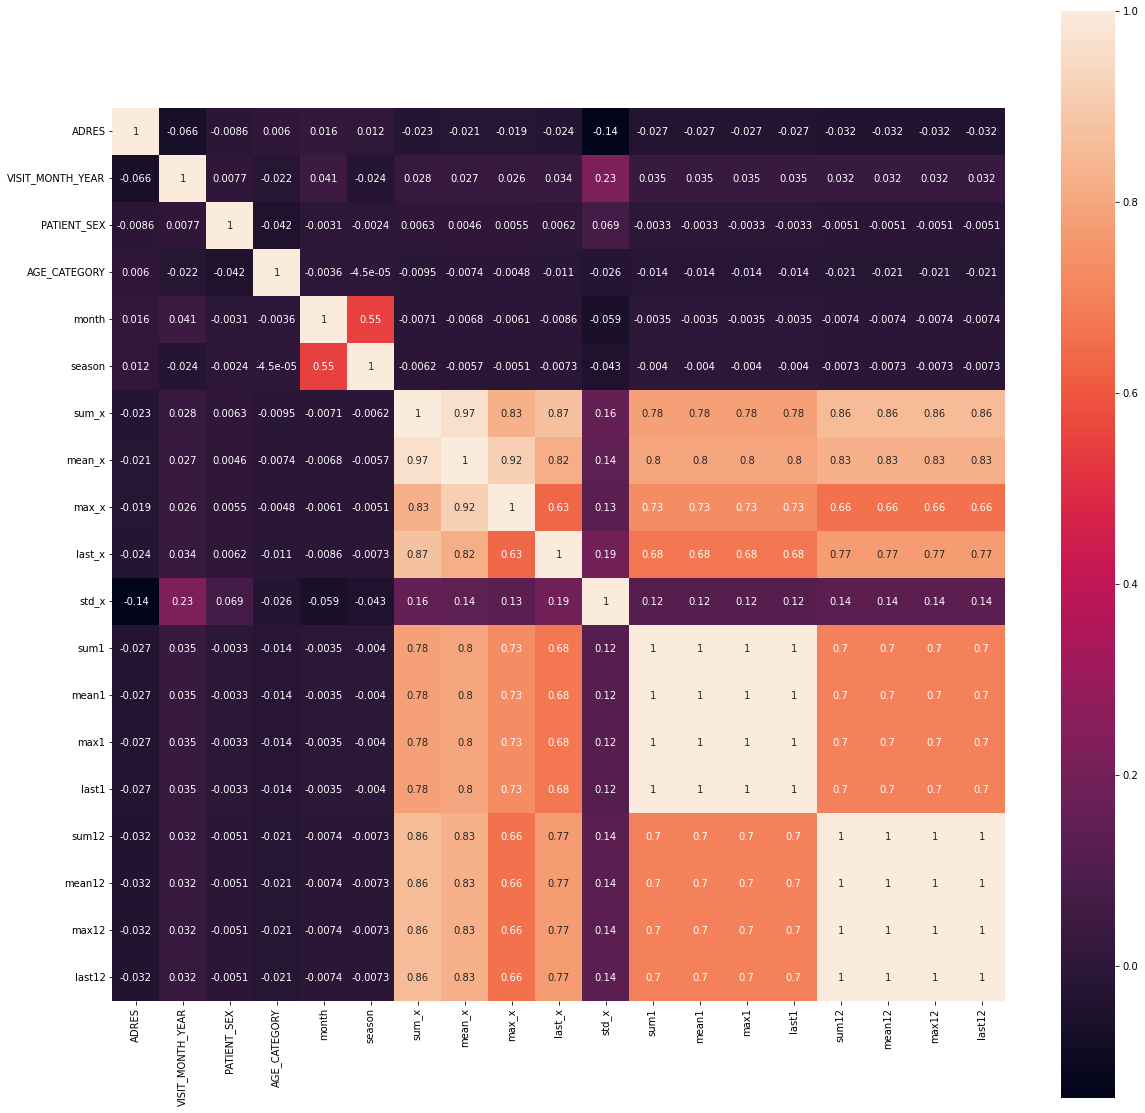

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,20)
sns.heatmap(X.corr(), square=True, annot=True)

In [56]:
test.merge(train[train['VISIT_MONTH_YEAR'].isin(['01.22', '02.22', '03.22'])].groupby(['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'], as_index=False)['PATIENT_ID_COUNT'].mean(),
        on=['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'],
        how='left').fillna(1).astype({'PATIENT_ID_COUNT': int}) # .to_csv('baseline_3m.csv', sep=';', index=None)


,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00,Калининград,04.22,children,2
1,0,A00,Калининград,04.22,elderly,1
2,0,A00,Калининград,04.22,middleage,1
3,0,A00,Калининград,04.22,young,3
4,0,A01,Калининград,04.22,middleage,1
...,...,...,...,...,...,...
39368,1,Z96.6,Балтийск,04.22,elderly,1
39369,1,Z96.6,Гусев,04.22,middleage,1
39370,1,Z96.7,Гусев,04.22,young,1
39371,1,Z98.8,Озерск,04.22,children,1


In [57]:
train[train['VISIT_MONTH_YEAR'].isin(['01.22', '02.22', '03.22'])].groupby(['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'AGE_CATEGORY'], as_index=False)['PATIENT_ID_COUNT'].mean()

,PATIENT_SEX,MKB_CODE,ADRES,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00,Калининград,children,2.5
1,0,A00,Калининград,elderly,1.0
2,0,A00,Калининград,middleage,1.0
3,0,A00,Калининград,young,3.0
4,0,A02.0,Гусев,children,1.0
...,...,...,...,...,...
51302,1,Z96.6,Советск,old,1.0
51303,1,Z98.8,Калининград,children,1.0
51304,1,Z98.8,Калининград,old,1.0
51305,1,Z98.8,Озерск,elderly,1.0


### Обучение

In [299]:
final_table.PATIENT_ID_COUNT.describe()

count    1.278733e+07
mean     1.011763e+00
std      2.523209e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.353200e+04
Name: PATIENT_ID_COUNT, dtype: float64

In [ ]:
#Разделение на train/test для локального тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=X.VISIT_MONTH_YEAR)

In [ ]:
cat_fts = [ 'VISIT_MONTH_YEAR', 'PATIENT_SEX', 'AGE_CATEGORY', 'connected', 'season', 'year', 'month', 'ADRES', 'MKB_CODE']
pool_train = Pool(X_train, y_train, cat_features = cat_fts)
pool_test = Pool(X_test, y_test, cat_features = cat_fts)

In [ ]:
model = CatBoostRegressor(task_type='CPU', iterations=90, random_seed=42, cat_features=cat_fts, eval_metric='R2')

In [ ]:
model.fit(pool_train, eval_set=pool_test, verbose=39, use_best_model=True, plot=True, early_stopping_rounds=30)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 0.6031858	test: 0.6217197	best: 0.6217197 (0)	total: 2.85s	remaining: 4m 13s
39:	learn: 0.9617769	test: 0.9536717	best: 0.9536717 (39)	total: 1m 1s	remaining: 1m 17s
78:	learn: 0.9738690	test: 0.9662464	best: 0.9662464 (78)	total: 2m 19s	remaining: 19.4s
89:	learn: 0.9760240	test: 0.9683362	best: 0.9683362 (89)	total: 2m 35s	remaining: 0us

bestTest = 0.9683361813
bestIteration = 89



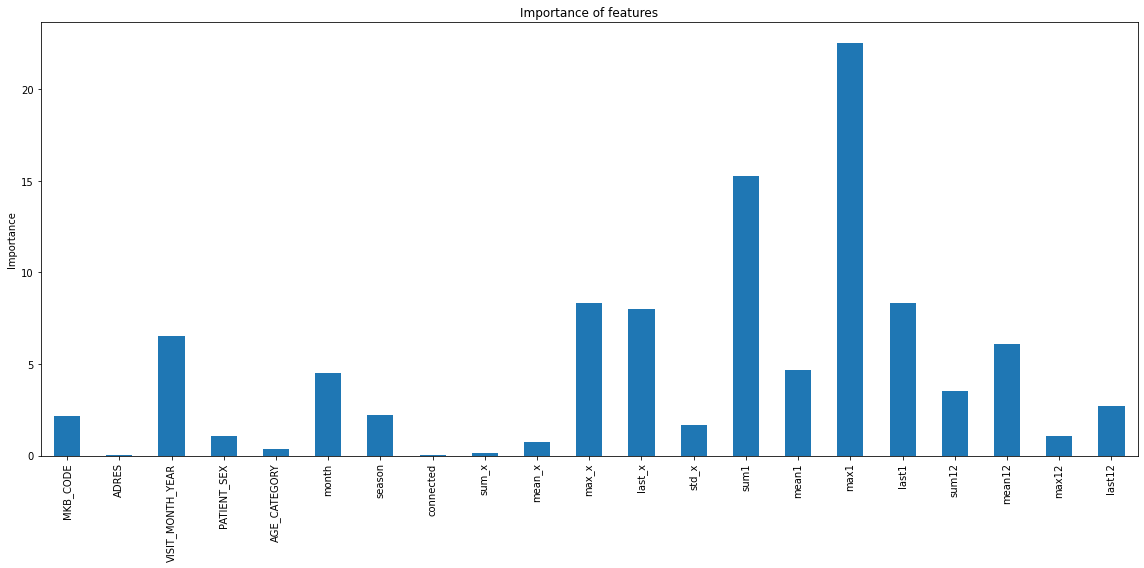

In [119]:
cat_feature_importance = model.get_feature_importance()
cat_importances = pd.Series(cat_feature_importance, index=X.columns)

fig, ax = plt.subplots(figsize=(16,8))
cat_importances.plot.bar(ax=ax)
ax.set_title("Importance of features")
ax.set_ylabel("Importance")
fig.tight_layout()

In [ ]:
#Получение ответов модели на тестовой выборке в локальном тестировании 
y_pred = model.predict(pool_test)
#На локальном тестировании модель выдаёт такой результат
print("Значение метрики R2 на test: ", r2_score(y_test, y_pred))

Значение метрики R2 на test:  0.9341609852502001


### Предсказание паблик теста

In [ ]:
test

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00,Калининград,04.22,children,0
1,0,A00,Калининград,04.22,elderly,0
2,0,A00,Калининград,04.22,middleage,0
3,0,A00,Калининград,04.22,young,0
4,0,A01,Калининград,04.22,middleage,0
...,...,...,...,...,...,...
39368,1,Z96.6,Балтийск,04.22,elderly,0
39369,1,Z96.6,Гусев,04.22,middleage,0
39370,1,Z96.7,Гусев,04.22,young,1
39371,1,Z98.8,Озерск,04.22,children,2


In [32]:
new_test = make_features(test, is_training = False)
new_test

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season
0,A00,29,04.22,0,1,4,22,0,0.000000,1
1,A00,29,04.22,0,2,4,22,0,0.000000,1
2,A00,29,04.22,0,3,4,22,0,0.000000,1
3,A00,29,04.22,0,5,4,22,0,0.000000,1
4,A01,29,04.22,0,3,4,22,0,0.010010,1
...,...,...,...,...,...,...,...,...,...,...
39368,Z96.6,1,04.22,1,2,4,22,24,0.966967,1
39369,Z96.6,14,04.22,1,3,4,22,24,0.966967,1
39370,Z96.7,14,04.22,1,5,4,22,24,0.967968,1
39371,Z98.8,66,04.22,1,1,4,22,24,0.988989,1


In [33]:
new_test['connected'] = new_test['AGE_CATEGORY'].astype('str') + '_' + new_test['ADRES'].astype('str') + '_' + new_test['MKB_CODE'].astype('str')
new_test

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,connected
0,A00,29,04.22,0,1,4,22,0,0.000000,1,1_29_A00
1,A00,29,04.22,0,2,4,22,0,0.000000,1,2_29_A00
2,A00,29,04.22,0,3,4,22,0,0.000000,1,3_29_A00
3,A00,29,04.22,0,5,4,22,0,0.000000,1,5_29_A00
4,A01,29,04.22,0,3,4,22,0,0.010010,1,3_29_A01
...,...,...,...,...,...,...,...,...,...,...,...
39368,Z96.6,1,04.22,1,2,4,22,24,0.966967,1,2_1_Z96.6
39369,Z96.6,14,04.22,1,3,4,22,24,0.966967,1,3_14_Z96.6
39370,Z96.7,14,04.22,1,5,4,22,24,0.967968,1,5_14_Z96.7
39371,Z98.8,66,04.22,1,1,4,22,24,0.988989,1,1_66_Z98.8


In [34]:
new_test = new_test.merge(b, left_on='connected', right_index=True, how='left')
new_test.columns = new_test.columns.to_list()[:-5] + ['sum_x', 'mean_x', 'max_x', 'last_x', 'std_x']
new_test.VISIT_MONTH_YEAR = 51

In [36]:
new_test['previous_month'] = new_test.VISIT_MONTH_YEAR.astype(int) - 1
new_test

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,connected,sum_x,mean_x,max_x,last_x,std_x,previous_month
0,A00,29,51,0,1,4,22,0,0.000000,1,1_29_A00,11.0,1.375000,4.0,1.0,8.0,50
1,A00,29,51,0,2,4,22,0,0.000000,1,2_29_A00,4.0,1.000000,1.0,1.0,4.0,50
2,A00,29,51,0,3,4,22,0,0.000000,1,3_29_A00,4.0,1.000000,1.0,1.0,4.0,50
3,A00,29,51,0,5,4,22,0,0.000000,1,5_29_A00,5.0,1.666667,3.0,3.0,3.0,50
4,A01,29,51,0,3,4,22,0,0.010010,1,3_29_A01,NaN,NaN,NaN,NaN,NaN,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39368,Z96.6,1,51,1,2,4,22,24,0.966967,1,2_1_Z96.6,24.0,1.333333,3.0,2.0,18.0,50
39369,Z96.6,14,51,1,3,4,22,24,0.966967,1,3_14_Z96.6,48.0,1.263158,2.0,1.0,38.0,50
39370,Z96.7,14,51,1,5,4,22,24,0.967968,1,5_14_Z96.7,NaN,NaN,NaN,NaN,NaN,50
39371,Z98.8,66,51,1,1,4,22,24,0.988989,1,1_66_Z98.8,1.0,1.000000,1.0,1.0,1.0,50


In [38]:
new_test['fully_connected'] = new_test['AGE_CATEGORY'].astype('str') + '_' + new_test['ADRES'].astype('str') + '_' + new_test['MKB_CODE'].astype('str') + '_' + new_test['PATIENT_SEX'].astype('str') + '_' + new_test['previous_month'].astype('str')
new_test = new_test.merge(d, left_on='fully_connected', right_index=True, how='left')
new_test.columns = new_test.columns.to_list()[:-5] + ['sum1', 'mean1', 'max1', 'last1', 'std1']
new_test

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,max_x,last_x,std_x,previous_month,fully_connected,sum1,mean1,max1,last1,std1
0,A00,29,51,0,1,4,22,0,0.000000,1,...,4.0,1.0,8.0,50,1_29_A00_0_50,4.0,4.0,4.0,4.0,1.0
1,A00,29,51,0,2,4,22,0,0.000000,1,...,1.0,1.0,4.0,50,2_29_A00_0_50,1.0,1.0,1.0,1.0,1.0
2,A00,29,51,0,3,4,22,0,0.000000,1,...,1.0,1.0,4.0,50,3_29_A00_0_50,1.0,1.0,1.0,1.0,1.0
3,A00,29,51,0,5,4,22,0,0.000000,1,...,3.0,3.0,3.0,50,5_29_A00_0_50,3.0,3.0,3.0,3.0,1.0
4,A01,29,51,0,3,4,22,0,0.010010,1,...,NaN,NaN,NaN,50,3_29_A01_0_50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39368,Z96.6,1,51,1,2,4,22,24,0.966967,1,...,3.0,2.0,18.0,50,2_1_Z96.6_1_50,NaN,NaN,NaN,NaN,NaN
39369,Z96.6,14,51,1,3,4,22,24,0.966967,1,...,2.0,1.0,38.0,50,3_14_Z96.6_1_50,NaN,NaN,NaN,NaN,NaN
39370,Z96.7,14,51,1,5,4,22,24,0.967968,1,...,NaN,NaN,NaN,50,5_14_Z96.7_1_50,NaN,NaN,NaN,NaN,NaN
39371,Z98.8,66,51,1,1,4,22,24,0.988989,1,...,1.0,1.0,1.0,50,1_66_Z98.8_1_50,NaN,NaN,NaN,NaN,NaN


In [39]:
new_test['fully_connected'] = new_test['AGE_CATEGORY'].astype('str') + '_' + new_test['ADRES'].astype('str') + '_' + new_test['MKB_CODE'].astype('str') + '_' + new_test['PATIENT_SEX'].astype('str') + '_' + (new_test['VISIT_MONTH_YEAR'] - 12).astype('str')
new_test = new_test.merge(d, left_on='fully_connected', right_index=True, how='left')
new_test.columns = new_test.columns.to_list()[:-5] + ['sum12', 'mean12', 'max12', 'last12', 'std12']
new_test

,MKB_CODE,ADRES,VISIT_MONTH_YEAR,PATIENT_SEX,AGE_CATEGORY,month,year,letter,number,season,...,sum1,mean1,max1,last1,std1,sum12,mean12,max12,last12,std12
0,A00,29,51,0,1,4,22,0,0.000000,1,...,4.0,4.0,4.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN
1,A00,29,51,0,2,4,22,0,0.000000,1,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,A00,29,51,0,3,4,22,0,0.000000,1,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,A00,29,51,0,5,4,22,0,0.000000,1,...,3.0,3.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN
4,A01,29,51,0,3,4,22,0,0.010010,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39368,Z96.6,1,51,1,2,4,22,24,0.966967,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39369,Z96.6,14,51,1,3,4,22,24,0.966967,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39370,Z96.7,14,51,1,5,4,22,24,0.967968,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39371,Z98.8,66,51,1,1,4,22,24,0.988989,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
    for j in [ex for ex in range(2, 25) if ex != 12]:
        new_test['fully_connected'] = new_test['AGE_CATEGORY'].astype('str') + '_' + new_test['ADRES'].astype('str') + '_' + new_test['MKB_CODE'].astype('str') + '_' + new_test['PATIENT_SEX'].astype('str') + '_' + (new_test['VISIT_MONTH_YEAR'] - j).astype('str')
        new_test = new_test.merge(d, left_on='fully_connected', right_index=True, how='left')
        new_test.columns = new_test.columns.to_list()[:-3] + [f'sum{j}', f'mean{j}', f'max{j}']

new_test['sum_dur_year1'] = new_test[all_cols[:36:3]].sum(axis=1)
new_test['mean_dur_year1'] = new_test[all_cols[1:35:3]].sum(axis=1) / 12
new_test['max_dur_year1'] = new_test[all_cols[2:36:3]].max(axis=1)

new_test['sum_dur_year2'] = new_test[all_cols[36:72:3]].sum(axis=1)
new_test['mean_dur_year2'] = new_test[all_cols[37:72:3]].sum(axis=1) / 12
new_test['max_dur_year2'] = new_test[all_cols[38:72:3]].max(axis=1)


In [123]:
# Формируем решение. В обучении используется весь train, ответы получаем на test
pool_test_solution = Pool(new_test, cat_features = cat_fts + ['fully_connected', 'year', 'letter'])

In [124]:
#Получение ответов
y_pred_solution = model.predict(pool_test_solution)

In [125]:
#Вот так они выглядят
y_pred_solution.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [126]:
#Формируем sample_solution для отправки на платформу

test['PATIENT_ID_COUNT'] = y_pred_solution.astype(int)
test['PATIENT_ID_COUNT'] = test['PATIENT_ID_COUNT'].apply(lambda x: x if x >= 0 else 1)
test

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00,Калининград,04.22,children,0
1,0,A00,Калининград,04.22,elderly,0
2,0,A00,Калининград,04.22,middleage,0
3,0,A00,Калининград,04.22,young,0
4,0,A01,Калининград,04.22,middleage,0
...,...,...,...,...,...,...
39368,1,Z96.6,Балтийск,04.22,elderly,0
39369,1,Z96.6,Гусев,04.22,middleage,0
39370,1,Z96.7,Гусев,04.22,young,0
39371,1,Z98.8,Озерск,04.22,children,0


In [127]:
test['PATIENT_ID_COUNT'].describe() # 

count    39373.000000
mean         3.702334
std         28.504571
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1766.000000
Name: PATIENT_ID_COUNT, dtype: float64

In [128]:
test['PATIENT_ID_COUNT'].value_counts()

0       28973
1        2764
2        1373
3         864
4         783
        ...  
1676        1
900         1
190         1
170         1
153         1
Name: PATIENT_ID_COUNT, Length: 223, dtype: int64

In [83]:
#Сохраняем в csv файл
test.to_csv('solution.csv', sep=';', index=None)